In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
ethnea_df = pd.read_csv('names_ethnea_genni_country.csv')
#ethnea_df

In [3]:
# First thing first, use the character feature for making the dnn model
def extract_structure(word,n_char=2):
    x_struct = []
    word_len = len(word) + n_char
    n_char-=1
    counter = 0
    for i in range(word_len):
        end = i+1
        start = (i - n_char) if (i - n_char) > 0 else 0
        if word[start:end]!='_' and word[start:end]!='':
        #if word[start:end]!='_':
            x_struct.append(word[start:end])
    return x_struct

first_name_struct = ethnea_df.First.apply(lambda x: extract_structure(x.lower(),2))
last_name_struct = ethnea_df.Last.apply(lambda x: extract_structure(x.lower(),2))                                                                

In [6]:
# make struct dictionary
struct_dict = {}
for name_struct_i in first_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

for name_struct_i in last_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

In [7]:
struct_dict_keys = {}
for i,key in enumerate(list(struct_dict.keys())):
    struct_dict_keys[key] = i
ethnic_series = ethnea_df['Ethnea'].str.lower()
ethnic_keys = list(np.unique(ethnic_series.values))

In [30]:
pub_series = ethnea_df.PubCountry.str.lower()
pub_keys = list(np.unique(pub_series.values))

In [8]:
# load test train data
with open('train_test_full_index.pickle', 'rb') as f:
    trainIndex,testIndex,trainY,testY = pickle.load(f)

In [9]:
# transform the dataset into structure
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

In [10]:
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys[x]+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

def generate_batch(first_name, i, batch_size=10000):
    len_name = len(first_name)
    start = i*batch_size
    end = start+batch_size if start+batch_size < len_name else len_name
    len_mat = end - start
    #first_name_ds_mat = np.zeros((len_mat,len(struct_dict_keys)),dtype=np.int32)
    #last_name_ds_mat = np.zeros((len_mat,50),dtype=np.int32)

    first_name_ds_mat = first_name[start:end]
    first_name_ds_mat = pad_sequences(first_name_ds_mat.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
    first_name_ds_mat = first_name_ds_mat.reshape(first_name_ds_mat.shape[0],1,first_name_ds_mat.shape[1])
    
    #last_name_ds_mat = last_name[start:end]
    #last_name_ds_mat = pad_sequences(last_name_ds_mat.apply(lambda x:transform_structure(x)),maxlen=50,value=0.)
    #last_name_ds_mat = last_name_ds_mat.reshape(last_name_ds_mat.shape[0],1,last_name_ds_mat.shape[1])

    """
    for i in range(len_mat):
        x = first_name_struct.iloc[i]
        for y in x:
            first_name_ds_mat[i,struct_dict_keys[y]]+=1
        #x = last_name_struct.iloc[i]
        #for y in x:
        #    last_name_ds_mat[i,struct_dict_keys.index(y)]+=1
    """
    return first_name_ds_mat, range(start,end)

In [11]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [32]:
import numpy as np
import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tflearn.data_utils import to_categorical, pad_sequences



In [22]:
from keras.models import model_from_json
# Model definition

# last_name_model
json_file = open('model-keras-w4-trigram-sep-last-lstm-full-hiddens.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

last_name_model = model_from_json(loaded_model_json)

last_name_model.load_weights("model-keras-w4-trigram-sep-last-lstm-full-hiddens-60.h5")
last_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# first_name_model
json_file = open('model-keras-w4-bigram-sep-first-full-lstm-hiddens.json')

loaded_model_json = json_file.read()
json_file.close()

first_name_model = model_from_json(loaded_model_json)

first_name_model.load_weights('model-keras-w4-bigram-sep-first-full-lstm-hiddens-15.h5')
first_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# first_name_pub_model

#first_name_pub_input = Input(shape=(len(pub_keys),),name='first_name_pub_input')
#merge_first_last = keras.layers.concatenate([fi,last_name_l])

In [23]:
first_name_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_name_input (InputLayer (None, None, 50)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000)              2204000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 26)                6526      
Total params: 2,836,276
Trainable params: 2,836,276
Non-trainable params: 0
_________________________________________________________________


In [41]:
# first_name_pub_model

first_name_model_input = first_name_model.get_layer('first_name_input').output
first_name_model_output = first_name_model.get_layer('dense_3').output

first_name_pub_input = Input(shape=(len(pub_keys),),name='first_name_pub_input')
merge_first_name_pub = keras.layers.concatenate([first_name_model_output,first_name_pub_input])
merge_first_name_pub_hidden = Dense(100, activation='relu')(merge_first_name_pub)
merge_first_name_pub_output = Dense(len(ethnic_keys),activation='softmax')(merge_first_name_pub_hidden)

first_name_pub_model = Model(inputs=[first_name_model_input,first_name_pub_input], outputs=[merge_first_name_pub_output])
first_name_pub_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [42]:
first_name_pub_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
first_name_input (InputLayer)    (None, None, 50)      0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 1000)          2204000     first_name_input[0][0]           
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 500)           500500      bidirectional_1[0][0]            
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 250)           125250      dense_1[0][0]                    
___________________________________________________________________________________________

In [44]:
# last_name_pub_model

last_name_model_input = last_name_model.get_layer('first_name_input').output
last_name_model_output = last_name_model.get_layer('dense_3').output

last_name_pub_input = Input(shape=(len(pub_keys),),name='last_name_pub_input')
merge_last_name_pub = keras.layers.concatenate([last_name_model_output,last_name_pub_input])
merge_last_name_pub_hidden = Dense(100, activation='relu')(merge_last_name_pub)
merge_last_name_pub_output = Dense(len(ethnic_keys),activation='softmax')(merge_last_name_pub_hidden)

last_name_pub_model = Model(inputs=[last_name_model_input,last_name_pub_input], outputs=[merge_last_name_pub_output])
last_name_pub_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [45]:
last_name_pub_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
first_name_input (InputLayer)    (None, None, 50)      0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 1000)          2204000     first_name_input[0][0]           
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 500)           500500      bidirectional_1[0][0]            
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 250)           125250      dense_1[0][0]                    
___________________________________________________________________________________________

In [49]:
# first_last_name_model

first_name_input = first_name_model.get_layer('first_name_input').output
first_name_output = first_name_model.get_layer('dense_3').output
last_name_input = last_name_model.get_layer('first_name_input').output
last_name_output = last_name_model.get_layer('dense_3').output
merge_first_last = keras.layers.concatenate([first_name_output,last_name_output])
merge_first_last_hidden = Dense(50, activation='relu')(merge_first_last)
first_last_name_output = Dense(len(ethnic_keys),activation='softmax')(merge_first_last_hidden)

first_last_name_model = Model(inputs=[first_name_input,last_name_input], outputs=[first_last_name_output])
first_last_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

RuntimeError: ('The name "first_name_input" is used 2 times in the model. All layer names should be unique. Layer names: ', ['first_name_input', 'first_name_input', 'bidirectional_1', 'bidirectional_1', 'dense_1', 'dense_1', 'dense_2', 'dense_2', 'dense_3', 'dense_3', 'concatenate_14', 'dense_21', 'dense_22'])

In [48]:
first_last_name_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
first_name_input (InputLayer)    (None, None, 50)      0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 1000)          2204000     first_name_input[0][0]           
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 500)           500500      bidirectional_1[0][0]            
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 250)           125250      dense_1[0][0]                    
___________________________________________________________________________________________

In [11]:
from keras.layers import Input
from keras.models import Model

"""
model = Sequential()
model.add(Embedding(len(name_struct_keys)+1,embedding_vector_length,input_length=max_sequence))
model.add(Conv1D(filters=embedding_vector_length,kernel_size=3,padding='same',activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_layer,dropout=0.8))
model.add(Bidirectional(LSTM(max_sequence*2,return_sequences=False),input_shape=(max_sequence,1)))
#model.add(TimeDistributed(keras.layers.Dense(len(ethnic_keys),activation='softmax')))
model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
#model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
"""


# max sequence length
seq_length = 50
# multi input with single output

# first name input
first_name_input = Input(shape=(None,50),name='first_name_input')
#last_name_input = Input(shape=(1,50),name='last_name_input')

# first tensor for first name
first_name_l = Bidirectional(LSTM(500,return_sequences=False))(first_name_input)
#last_name_l = Bidirectional(LSTM(1000,return_sequences=False))(last_name_input)

# merge the two layer together
#x = keras.layers.concatenate([first_name_l])

# stack dense network for memory
x = Dense(500, activation='relu')(first_name_l)
x = Dense(250, activation='relu')(x)
output_l = Dense(len(ethnic_keys),activation='softmax')(x)

model = Model(inputs=[first_name_input], outputs=[output_l])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

"""
from keras.layers import Input
from keras.models import Model

# max sequence length
seq_length = 100
# multi input with single output

# first name input
first_name_input = Input(shape=(len(struct_dict_keys),),name='first_name_input')
#last_name_input = Input(shape=(len(struct_dict_keys),),name='last_name_input')

# first tensor for first name
first_name_l = Dense(units=500)(first_name_input)
#last_name_l = Dense(units=1000)(last_name_input)

# merge the two layer together
#x = keras.layers.concatenate([first_name_l,last_name_l])

# stack dense network for memory
x = Dense(250, activation='relu')(first_name_l)
x = Dense(100, activation='relu')(x)
output_l = Dense(len(ethnic_keys),activation='softmax')(x)

model = Model(inputs=[first_name_input], outputs=[output_l])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
"""

"\nfrom keras.layers import Input\nfrom keras.models import Model\n\n# max sequence length\nseq_length = 100\n# multi input with single output\n\n# first name input\nfirst_name_input = Input(shape=(len(struct_dict_keys),),name='first_name_input')\n#last_name_input = Input(shape=(len(struct_dict_keys),),name='last_name_input')\n\n# first tensor for first name\nfirst_name_l = Dense(units=500)(first_name_input)\n#last_name_l = Dense(units=1000)(last_name_input)\n\n# merge the two layer together\n#x = keras.layers.concatenate([first_name_l,last_name_l])\n\n# stack dense network for memory\nx = Dense(250, activation='relu')(first_name_l)\nx = Dense(100, activation='relu')(x)\noutput_l = Dense(len(ethnic_keys),activation='softmax')(x)\n\nmodel = Model(inputs=[first_name_input], outputs=[output_l])\nmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])\n"

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_name_input (InputLayer (None, None, 50)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000)              2204000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 26)                6526      
Total params: 2,836,276
Trainable params: 2,836,276
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.summary()
#first_trainX = first_name_struct[trainIndex]
#first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

#trainX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in trainX])
#testX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in testX])

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 10000

for x in range(1):
    for y in range(len_mini_batch):
        y_first_trainX, batch_range =  generate_batch(last_trainX,y,mini_batch_size)
        model.fit([y_first_trainX],trainY[batch_range],epochs=1,batch_size=batch_size)
        #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_name_input (InputLayer (None, None, 50)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000)              2204000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 26)                6526      
Total params: 2,836,276
Trainable params: 2,836,276
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
50000/50000 [==============================] - 21s - loss: 2.6299 - acc: 0.2819    
Epoch 1/1
50000/50000 [===============

In [14]:
for x in range(10):
    print('batch {}'.format(x))
    for y in range(len_mini_batch):
        y_first_trainX, batch_range =  generate_batch(last_trainX,y,mini_batch_size)
        model.fit([y_first_trainX],trainY[batch_range],epochs=1,batch_size=batch_size)
        #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 0
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2791 - acc: 0.6324    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2743 - acc: 0.6338    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2777 - acc: 0.6337    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2747 - acc: 0.6343    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2583 - acc: 0.6375    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2586 - acc: 0.6382    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2607 - acc: 0.6371    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2503 - acc: 0.6386    
Epoch 1/1
50000/50000 [==============================] - 18s - loss: 1.2484 - acc: 0.6407    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.2455 - acc: 0.6423    
Epoch 1/1
50000/50000 [=============================

50000/50000 [==============================] - 17s - loss: 1.0254 - acc: 0.7044    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 1.0306 - acc: 0.7009    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 1.0290 - acc: 0.7053    
Epoch 1/1
50000/50000 [==============================] - 22s - loss: 1.0189 - acc: 0.7097    
Epoch 1/1
50000/50000 [==============================] - 18s - loss: 1.0142 - acc: 0.7088    
Epoch 1/1
50000/50000 [==============================] - 18s - loss: 1.0213 - acc: 0.7061    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 1.0269 - acc: 0.7039    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 1.0252 - acc: 0.7080    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 1.0179 - acc: 0.7068    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 1.0255 - acc: 0.7068    
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1

50000/50000 [==============================] - 15s - loss: 0.9166 - acc: 0.7360    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9404 - acc: 0.7290    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9340 - acc: 0.7314    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9397 - acc: 0.7287    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.9296 - acc: 0.7323    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9294 - acc: 0.7319    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9250 - acc: 0.7338    
Epoch 1/1
47268/47268 [==============================] - 14s - loss: 0.9283 - acc: 0.7292    
batch 5
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9393 - acc: 0.7296    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9388 - acc: 0.7294    
Epoch 1/1
50000/50000 [==============================] - 16s -

50000/50000 [==============================] - 15s - loss: 0.9037 - acc: 0.7392    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9002 - acc: 0.7378    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8941 - acc: 0.7424    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9024 - acc: 0.7391    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9014 - acc: 0.7398    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8942 - acc: 0.7421    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.9019 - acc: 0.7384    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.8949 - acc: 0.7440    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.9007 - acc: 0.7390    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.9009 - acc: 0.7410    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.8508 - acc: 0.7518    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8507 - acc: 0.7520    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.8419 - acc: 0.7558    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8568 - acc: 0.7534    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.8541 - acc: 0.7506    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.8363 - acc: 0.7573    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8553 - acc: 0.7547    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8499 - acc: 0.7541    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8552 - acc: 0.7517    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.8458 - acc: 0.7542    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

In [17]:
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

#trainX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in trainX])
#testX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in testX])

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 10000

for x in range(10):
    print('batch {}'.format(x))
    for y in range(len_mini_batch):
        y_first_trainX, batch_range =  generate_batch(last_trainX,y,mini_batch_size)
        model.fit([y_first_trainX],trainY[batch_range],epochs=1,batch_size=batch_size)
        #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 0
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 1.3183 - acc: 0.6602    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 1.1161 - acc: 0.6924    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 1.0064 - acc: 0.7095    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.9549 - acc: 0.7243    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.8966 - acc: 0.7394    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8744 - acc: 0.7482    
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 0.8553 - acc: 0.7523    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8392 - acc: 0.7562    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8328 - acc: 0.7577    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8185 - acc: 0.7634    
Epoch 1/1
50000/50000 [=============================

50000/50000 [==============================] - 15s - loss: 0.7986 - acc: 0.7689    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8055 - acc: 0.7656    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8030 - acc: 0.7651    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7909 - acc: 0.7701    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7897 - acc: 0.7717    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7947 - acc: 0.7676    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8026 - acc: 0.7666    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7965 - acc: 0.7703    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7955 - acc: 0.7680    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.8007 - acc: 0.7683    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.7634 - acc: 0.7791    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7795 - acc: 0.7719    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7747 - acc: 0.7750    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7819 - acc: 0.7731    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7776 - acc: 0.7735    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7788 - acc: 0.7717    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7745 - acc: 0.7756    
Epoch 1/1
47268/47268 [==============================] - 14s - loss: 0.7718 - acc: 0.7743    
batch 5
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7842 - acc: 0.7701    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7808 - acc: 0.7723    
Epoch 1/1
50000/50000 [==============================] - 15s -

50000/50000 [==============================] - 15s - loss: 0.7666 - acc: 0.7744    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7638 - acc: 0.7774    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7584 - acc: 0.7792    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7631 - acc: 0.7770    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7672 - acc: 0.7763    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7591 - acc: 0.7803    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7681 - acc: 0.7748    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7642 - acc: 0.7788    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7642 - acc: 0.7794    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7707 - acc: 0.7766    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.7502 - acc: 0.7807    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7494 - acc: 0.7796    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7405 - acc: 0.7822    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7492 - acc: 0.7807    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7536 - acc: 0.7784    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7374 - acc: 0.7834    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7586 - acc: 0.7803    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7497 - acc: 0.7820    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7563 - acc: 0.7802    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7451 - acc: 0.7836    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

In [21]:
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

#trainX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in trainX])
#testX =np.array([to_categorical(x,nb_classes=len(struct_dict_keys)+1) for x in testX])

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 10000

for x in range(30):
    print('batch {}'.format(x))
    for y in range(len_mini_batch):
        y_first_trainX, batch_range =  generate_batch(last_trainX,y,mini_batch_size)
        model.fit([y_first_trainX],trainY[batch_range],epochs=1,batch_size=batch_size)
        #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 0
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6941 - acc: 0.7955    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6880 - acc: 0.7961    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.7045 - acc: 0.7928    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6986 - acc: 0.7965    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6916 - acc: 0.7958    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6915 - acc: 0.7984    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6966 - acc: 0.7947    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6896 - acc: 0.7964    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6871 - acc: 0.7965    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6876 - acc: 0.7977    
Epoch 1/1
50000/50000 [=============================

50000/50000 [==============================] - 15s - loss: 0.6794 - acc: 0.8006    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6794 - acc: 0.8000    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6831 - acc: 0.7968    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6779 - acc: 0.8019    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6748 - acc: 0.8011    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6777 - acc: 0.8010    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6842 - acc: 0.7995    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6770 - acc: 0.8001    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6690 - acc: 0.8030    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6793 - acc: 0.7992    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6579 - acc: 0.8058    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6745 - acc: 0.7984    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6672 - acc: 0.8033    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6735 - acc: 0.8020    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6666 - acc: 0.8049    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6668 - acc: 0.8031    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6666 - acc: 0.8042    
Epoch 1/1
47268/47268 [==============================] - 14s - loss: 0.6603 - acc: 0.8045    
batch 5
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6777 - acc: 0.8007    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6717 - acc: 0.8013    
Epoch 1/1
50000/50000 [==============================] - 15s -

50000/50000 [==============================] - 15s - loss: 0.6698 - acc: 0.8021    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6624 - acc: 0.8042    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6670 - acc: 0.8031    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6665 - acc: 0.8034    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6662 - acc: 0.8028    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6639 - acc: 0.8053    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6685 - acc: 0.8015    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6664 - acc: 0.8038    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6696 - acc: 0.8042    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6684 - acc: 0.8055    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6584 - acc: 0.8059    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6583 - acc: 0.8076    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6542 - acc: 0.8058    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6614 - acc: 0.8033    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6617 - acc: 0.8039    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6515 - acc: 0.8081    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6643 - acc: 0.8032    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6560 - acc: 0.8068    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6631 - acc: 0.8044    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6538 - acc: 0.8070    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6522 - acc: 0.8054    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6680 - acc: 0.8026    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6636 - acc: 0.8061    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6594 - acc: 0.8063    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6594 - acc: 0.8050    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6611 - acc: 0.8044    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6521 - acc: 0.8063    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6510 - acc: 0.8061    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6475 - acc: 0.8090    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6525 - acc: 0.8064    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6462 - acc: 0.8085    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6464 - acc: 0.8111    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6419 - acc: 0.8114    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6450 - acc: 0.8095    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6525 - acc: 0.8072    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6482 - acc: 0.8083    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6383 - acc: 0.8110    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6420 - acc: 0.8105    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6399 - acc: 0.8117    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6379 - acc: 0.8108    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6324 - acc: 0.8118    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6446 - acc: 0.8103    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6393 - acc: 0.8118    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6400 - acc: 0.8093    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6379 - acc: 0.8125    
Epoch 1/1
47268/47268 [==============================] - 14s - loss: 0.6272 - acc: 0.8119    
batch 16
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6486 - acc: 0.8068    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6382 - acc: 0.8107    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6571 - acc: 0.8058    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6500 - acc: 0.8098    
Epoch 1/1
50000/50000 [==============================] - 15s 

50000/50000 [==============================] - 15s - loss: 0.6386 - acc: 0.8091    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6376 - acc: 0.8122    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6406 - acc: 0.8105    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6358 - acc: 0.8108    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6366 - acc: 0.8111    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6372 - acc: 0.8100    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6410 - acc: 0.8130    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6372 - acc: 0.8143    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6373 - acc: 0.8119    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6315 - acc: 0.8124    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6298 - acc: 0.8118    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6320 - acc: 0.8101    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6393 - acc: 0.8092    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6283 - acc: 0.8122    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6388 - acc: 0.8108    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6280 - acc: 0.8136    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6329 - acc: 0.8123    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6247 - acc: 0.8132    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6218 - acc: 0.8145    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6340 - acc: 0.8129    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6355 - acc: 0.8123    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6329 - acc: 0.8115    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6365 - acc: 0.8119    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6362 - acc: 0.8105    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6275 - acc: 0.8137    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6271 - acc: 0.8137    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6221 - acc: 0.8152    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6291 - acc: 0.8119    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6292 - acc: 0.8125    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6276 - acc: 0.8135    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6155 - acc: 0.8169    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6163 - acc: 0.8172    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6251 - acc: 0.8139    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6206 - acc: 0.8137    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6124 - acc: 0.8179    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6185 - acc: 0.8160    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6180 - acc: 0.8169    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6150 - acc: 0.8167    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6225 - acc: 0.8140    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6251 - acc: 0.8128    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

50000/50000 [==============================] - 15s - loss: 0.6144 - acc: 0.8181    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6094 - acc: 0.8174    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6160 - acc: 0.8174    
Epoch 1/1
47268/47268 [==============================] - 14s - loss: 0.6004 - acc: 0.8188    
batch 27
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6256 - acc: 0.8121    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6183 - acc: 0.8153    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6358 - acc: 0.8105    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6299 - acc: 0.8148    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6226 - acc: 0.8134    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6241 - acc: 0.8147    
Epoch 1/1
50000/50000 [==============================] - 15s 

50000/50000 [==============================] - 15s - loss: 0.6161 - acc: 0.8179    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6125 - acc: 0.8193    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6154 - acc: 0.8151    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6146 - acc: 0.8169    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6173 - acc: 0.8168    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6162 - acc: 0.8179    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6154 - acc: 0.8164    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6129 - acc: 0.8158    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6185 - acc: 0.8166    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0.6099 - acc: 0.8185    
Epoch 1/1
50000/50000 [==============================] - 15s - loss: 0

In [18]:
# evaluation
def evaluate(firstX, testY, testIndex, mini_batch_size=20000):
    test_len = len(testY)
    len_mini_batch = round(test_len/mini_batch_size)
    scores = np.zeros(len_mini_batch)
    for i in range(len_mini_batch):
        y_first_trainX,batch_range = generate_batch(firstX,i,mini_batch_size)
        #pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))
        scores[i] = model.evaluate([y_first_trainX],testY[batch_range])[1]
        print(scores[i])
    return np.average(scores)
    #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    

In [19]:
evaluate(last_testX, testY, testIndex)

20000/20000 [==============================] - 2s     
0.639
20000/20000 [==============================] - 1s     
0.6404
20000/20000 [==============================] - 1s     
0.63585
20000/20000 [==============================] - 1s     
0.6471
19488/20000 [============================>.] - ETA: 0s0.6417


0.64241931818181819

In [25]:
evaluate(last_testX, testY, testIndex)

20000/20000 [==============================] - 2s     
0.6935
20000/20000 [==============================] - 2s     
0.6935
20000/20000 [==============================] - 1s     
0.69025
19648/20000 [============================>.] - ETA: 0s0.6888


0.68976136363636364

In [69]:
evaluate(first_testX,last_testX, testY, testIndex)

20000/20000 [==============================] - 31s    
0.8889
20000/20000 [==============================] - 31s    
0.88475
20000/20000 [==============================] - 30s    
0.88735
20000/20000 [==============================] - 30s    
0.88125
20000/20000 [==============================] - 30s    
0.8872
20000/20000 [==============================] - 30s    
0.8833
20000/20000 [==============================] - 30s    
0.88535
20000/20000 [==============================] - 29s    
0.8901
20000/20000 [==============================] - 30s    
0.8882
20000/20000 [==============================] - 31s    
0.8858
20000/20000 [==============================] - 32s    
0.883
20000/20000 [==============================] - 30s    
0.8849
20000/20000 [==============================] - 30s    
0.88515
20000/20000 [==============================] - 30s    
0.88035
20000/20000 [==============================] - 30s    
0.88705
20000/20000 [==============================] - 30s    
0.88485
2

0.8858284090909091

In [22]:
def trans_name(name):
    name = name.lower()
    # transform space into underscore
    name = '_'+name.replace(' ','_')+'_'
    #transform the name into sequence structure
    ext_name = extract_structure(name)
    trans_name = transform_structure(ext_name)
    """
    name_ds_mat = np.zeros((1,len(struct_dict_keys)),dtype=np.int32)
    for i,x in enumerate(trans_name):
        name_ds_mat[0,x-1]+=1
    """
    trans_name = pad_sequences([trans_name], maxlen=50,value=0.)
    trans_name = trans_name.reshape(trans_name.shape[0],1,trans_name.shape[1])
    return trans_name

def predict_ethnicity(fname,lname):
    # lower case the name
    fnamex = trans_name(fname)
    lnamex = trans_name(lname)
    pred = model.predict([np.array(fnamex),np.array(lnamex)])
    pred_class = np.argsort(pred[0])[::-1]
    return_item = []
    for x in np.argsort(pred[0])[::-1]:
        return_item.append((ethnic_keys[x],pred[0][x]))
    return return_item

In [110]:
predict_ethnicity('','Torvik')
#trans_name('Nikolaus')

[('african', 0.27813491),
 ('italian', 0.23668645),
 ('arab', 0.16545378),
 ('english', 0.090604469),
 ('hispanic', 0.072399184),
 ('greek', 0.069882892),
 ('german', 0.026815478),
 ('chinese', 0.021262014),
 ('indian', 0.011392869),
 ('israeli', 0.0087896977),
 ('slav', 0.0053151767),
 ('nordic', 0.0040396359),
 ('korean', 0.0028781292),
 ('hungarian', 0.0020560659),
 ('japanese', 0.0015827892),
 ('french', 0.001556474),
 ('indonesian', 0.00036203483),
 ('dutch', 0.00035687571),
 ('romanian', 0.00026695983),
 ('vietnamese', 9.1479924e-05),
 ('thai', 4.3133787e-05),
 ('turkish', 1.632263e-05),
 ('polynesian', 7.9904157e-06),
 ('mongolian', 3.8686217e-06),
 ('caribbean', 1.3170746e-06),
 ('baltic', 3.08091e-09)]

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(predicting_error, class_error)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys,
                      title='Confusion matrix')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [8]:
# embedd the structure vocabulary using text embedding and reduce the dimensionality

# convert the names into word structure vector
struct_dict_keys = list(struct_dict.keys())

def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

In [9]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [16]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import pickle

with open('train_test_fix.pickle', 'rb') as f:
    trainX,trainY,testX,testY,ethnic_keys,struct_dict_keys = pickle.load(f)
    #aha = pickle.load(f)

#with open('traintest-smote.pickle','rb') as f:
#    train_res,test_res = pickle.load(f)

with open('ethnic_keys.pickle','rb') as f:
    name_struct_keys,ethnic_keys = pickle.load(f)
        
embedding_vector_length = 1000
lstm_layer = 1000
max_sequence = 50

In [ ]:
# convert categorical to binary crossentropy
#trainY = np.array([np.where(x>0)[0][0] for x in trainY])
#testY = np.array([np.where(x>0)[0][0] for x in testY])

#test_res

In [2]:
model = Sequential()
model.add(Embedding(len(name_struct_keys)+1,embedding_vector_length,input_length=max_sequence))
model.add(Conv1D(filters=embedding_vector_length,kernel_size=3,padding='same',activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_layer,dropout=0.8))
model.add(Bidirectional(LSTM(max_sequence*2,return_sequences=False),input_shape=(max_sequence,1)))
#model.add(TimeDistributed(keras.layers.Dense(len(ethnic_keys),activation='softmax')))
model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
#model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
for x in range(10):
    model.fit(trainX,trainY,epochs=1,batch_size=1000)
    scores = model.evaluate(testX,testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 1000)          62696000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 1000)          3001000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               880800    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4623      
Total params: 66,582,423
Trainable params: 66,582,423
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
35653/35653 [==============================] - 778s - loss: 1.6879 - acc: 0.5265    
Accuracy: 75.88%
Epoch 1/1
35653/35653 [==============================] - 796s - loss: 0.5197 - acc: 0.8582    
Accuracy: 84.37%
Epoch 1/1
35653/35653 [==========

In [4]:
testX

array([[  112,  1331,  1332, ...,     0,     0,     0],
       [  251,   252,   232, ...,     0,     0,     0],
       [ 4633, 11731, 23123, ...,     0,     0,     0],
       ..., 
       [  696,   697,   698, ...,     0,     0,     0],
       [   25,    26,  5195, ...,     0,     0,     0],
       [ 8671,  8672,  6568, ...,     0,     0,     0]], dtype=int32)

In [91]:
# store the predictions probabilities, predictions and labels
"""
# make a confusion matrix
pred = loaded_model.predict([first_testX,last_testX])
# pred probability distribution

pred_class = np.array([np.argsort(x)[::-1][0] for x in pred])
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

pred_prob = []
predictions = []
"""

def evaluate_probs(firstX, lastX, testY, testIndex, mini_batch_size=20000):
    test_class = []
    pred_class = []    
    pred_prob = []
    
    test_len = len(testY)
    len_mini_batch = round(test_len/mini_batch_size)+1
    print(len_mini_batch)
    for i in range(len_mini_batch):
        print(i)
        y_first_trainX,y_last_trainX,batch_range = generate_batch(firstX,lastX,i,mini_batch_size)
        #pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))        
        pred = model.predict([y_first_trainX,y_last_trainX])
        pred_class_inn =  [np.argsort(x)[::-1][0] for x in pred]
        pred_class.extend(pred_class_inn)
        pred_prob.extend([x[np.argsort(x)[::-1][0]] for x in pred])
    return pred_class,pred_prob
    #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    

In [92]:
#pred_class, pred_prob = evaluate_probs(first_testX[0:100],last_testX[0:100], testY[0:100], testIndex)
pred_class, pred_prob = evaluate_probs(first_testX,last_testX, testY, testIndex)

45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


(array([  2.07000000e+02,   2.28700000e+03,   7.56300000e+03,
          1.39370000e+04,   2.28850000e+04,   2.34090000e+04,
          2.51430000e+04,   3.02170000e+04,   4.46390000e+04,
          7.16530000e+05]),
 array([ 0.14609675,  0.23148708,  0.3168774 ,  0.40226773,  0.48765805,
         0.57304838,  0.6584387 ,  0.74382903,  0.82921935,  0.91460968,  1.        ]),
 <a list of 10 Patch objects>)

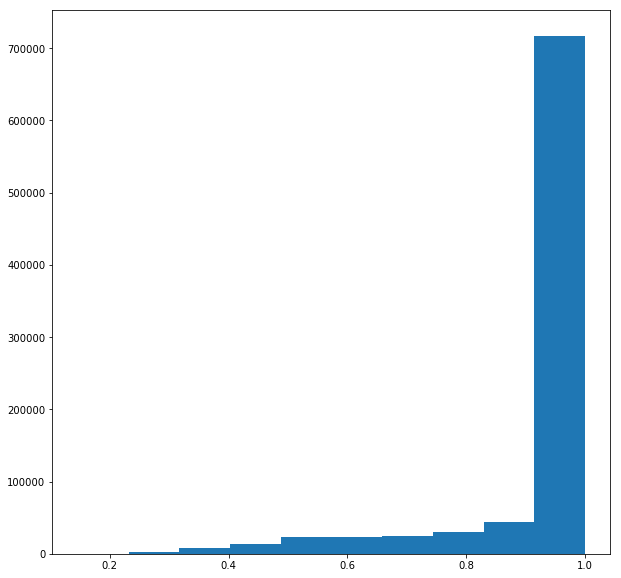

In [95]:
fig,ax = plt.subplots(figsize=(10,10))
ax.hist(pred_prob)

In [102]:
pred_class = np.array(pred_class)
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

Confusion matrix, without normalization


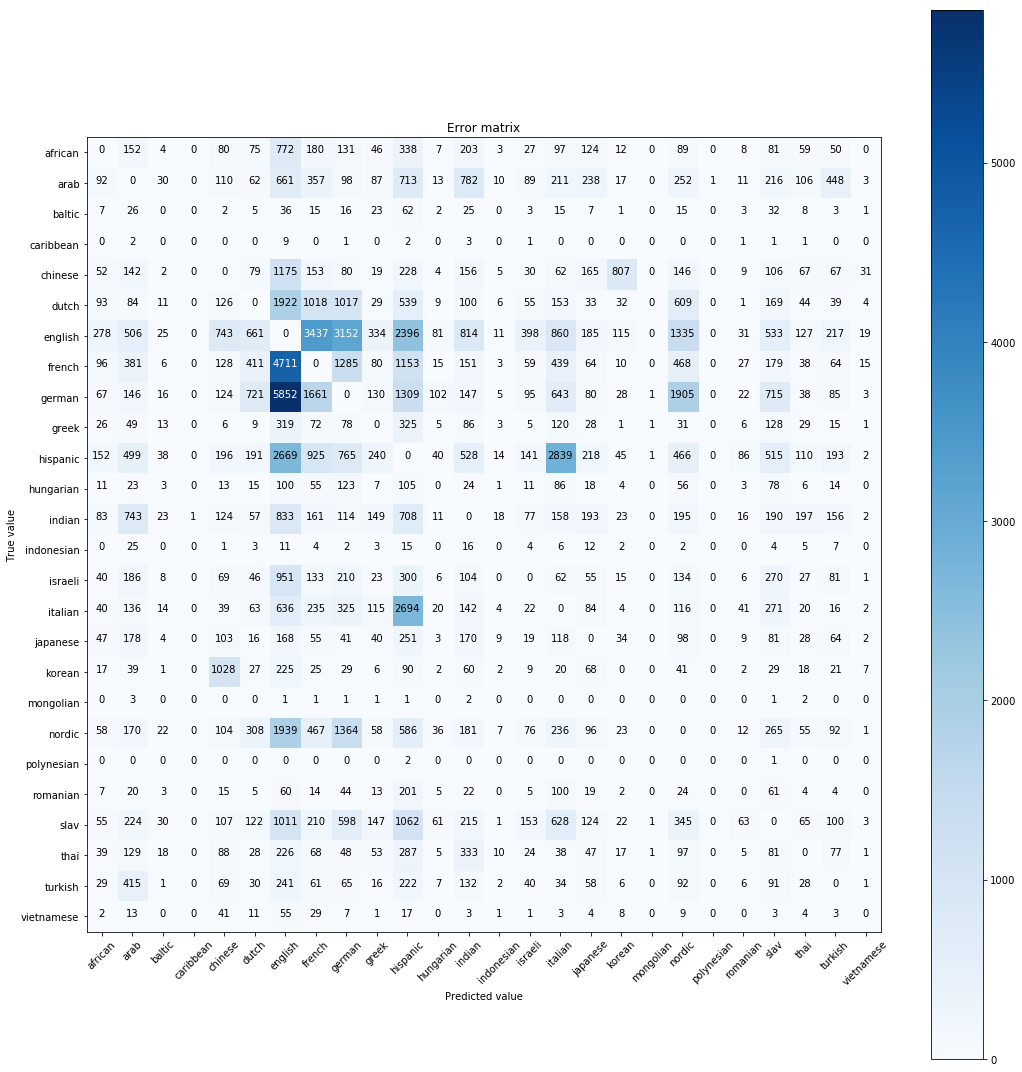

In [103]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value')

# Compute confusion matrix
cnf_matrix = confusion_matrix(predicting_error, class_error)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys,
                      title='Error matrix')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [111]:
len(struct_dict_keys)

725

In [112]:
struct_dict_keys

['_c',
 'ca',
 'am',
 'me',
 'er',
 'ro',
 'on',
 'n_',
 '_b',
 'be',
 'rt',
 't_',
 '_l',
 'le',
 'ee',
 'en',
 '_e',
 'es',
 'st',
 'th',
 'he',
 'r_',
 'el',
 'll',
 '_p',
 'pe',
 'et',
 'te',
 '_g',
 'ge',
 '_m',
 'ma',
 'ax',
 'x_',
 '_k',
 'kh',
 'ha',
 'al',
 'ed',
 'd_',
 'la',
 'an',
 'ni',
 'ie',
 'e_',
 'eu',
 'un',
 'ic',
 'ce',
 'ch',
 'hr',
 'ri',
 'is',
 'to',
 'op',
 'ph',
 '_j',
 'jo',
 'oo',
 'os',
 '_i',
 'ia',
 'ka',
 'at',
 'hl',
 '_t',
 'rr',
 're',
 'nc',
 'ju',
 'ul',
 'li',
 'iu',
 'us',
 's_',
 '_a',
 'mr',
 'mi',
 'ig',
 'gu',
 'ue',
 'l_',
 '_n',
 'ne',
 'ei',
 'il',
 'je',
 'oe',
 '_h',
 'hy',
 'yu',
 'ah',
 'h_',
 'ar',
 'rk',
 'k_',
 'ab',
 'bd',
 '_s',
 'se',
 'rg',
 'gi',
 'io',
 'o_',
 'uu',
 'dr',
 'pa',
 'au',
 'ja',
 'ik',
 'ke',
 'mu',
 'ir',
 'na',
 '_r',
 'rd',
 'rn',
 'ns',
 'as',
 'sw',
 'wa',
 'nt',
 'ur',
 '_d',
 'de',
 'og',
 'ho',
 'or',
 'ra',
 'ay',
 'ya',
 'a_',
 'em',
 'ad',
 'ak',
 'su',
 'u_',
 '_y',
 'yo',
 'ou',
 'si',
 'if',
 'f_',